<a href="https://colab.research.google.com/github/w3gilberto/projetoSRI/blob/main/Projeto_SRI_GilbertoRamos___Gensim_word2vec_reviews_airbnb_Rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto da Disciplina SRI - Prof Flávio Codeço Coelho - Aluno: Gilberto Ramos - 30.11.2021
## Análise textual e de similaridades de palavras em avaliações de hóspedes no airbnb usando Gensim-Word2vec e SpaCy.



In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm
#from gensim.models.tfidfmodel import TfidfModel
import nltk
nltk.download('stopwords')
import spacy.cli 
spacy.cli.download("pt_core_news_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


# Fonte do Dataset Airbnb Rio de Janeiro - reviews de 2010 a 2021

fonte do Dataset: Kaggle 
https://www.kaggle.com/vabatista/airbnb-rio-de-janeiro?select=reviews.csv


In [5]:
from google.colab import files 
uploaded = files.upload()
df = pd.read_csv('reviews_airbnb_Rio_.csv')



Saving reviews_airbnb_Rio_.csv to reviews_airbnb_Rio_.csv


In [6]:
df.head(100)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,17878,64852,2010-07-15,135370,Tia,This apartment is in a perfect location -- two...
1,17878,76744,2010-08-11,10206,Mimi,we had a really great experience staying in Ma...
2,17878,91074,2010-09-06,80253,Jan,Staying in Max appartment is like living in a ...
3,17878,137528,2010-11-12,230449,Orene,In general very good and reasonable price.\r\n...
4,17878,147594,2010-12-01,219338,David,The apt was nice and in a great location only ...
...,...,...,...,...,...,...
95,17878,12909299,2014-05-13,11104956,Grant,If you are staying in Copacabana and want grea...
96,17878,14110065,2014-06-12,11057119,Lucie,Everything perfect. The apartment is very nice...
97,17878,14767662,2014-06-26,5133473,Andrew,My friends and I all enjoyed our time at Max's...
98,17878,16657506,2014-07-31,15582950,Fabiano,Tudo correu muito bem! O apartamento é muito b...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16131 entries, 0 to 16130
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     16131 non-null  int64 
 1   id             16131 non-null  int64 
 2   date           16131 non-null  object
 3   reviewer_id    16131 non-null  int64 
 4   reviewer_name  16131 non-null  object
 5   comments       16129 non-null  object
dtypes: int64(3), object(3)
memory usage: 756.3+ KB


In [8]:
df.shape

(16131, 6)

In [9]:
df.isna().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         2
dtype: int64

**Pré-processamento**

In [11]:
dummy_data = df[['date','reviewer_name','comments']]

vamos combinar 'text' = 'reviewer_name' e 'comments'

In [12]:
dummy_data['text'] = dummy_data['reviewer_name'] + ' ' + dummy_data['comments']
dummy_data = dummy_data.drop(['reviewer_name', 'comments'], axis=1)
dummy_data.head()

INFO - 12:56:24: NumExpr defaulting to 2 threads.


,date,text
0,2010-07-15,Tia This apartment is in a perfect location --...
1,2010-08-11,Mimi we had a really great experience staying ...
2,2010-09-06,Jan Staying in Max appartment is like living i...
3,2010-11-12,Orene In general very good and reasonable pric...
4,2010-12-01,David The apt was nice and in a great location...


**limpeza do texto**

Estamos lematizando e removendo as palavras irrelevantes e os caracteres não alfabéticos de cada linha.

Para este propósito, estamos usando SpaCy e seu pipeline integrado.

In [13]:
nlp = spacy.load("pt_core_news_sm", disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    #remove stopwords + Lemmatize them 
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # word2vec uses context words to learn the vector representation of a terget word 
    # if sentence is only one or two worlds long,
    # the benifit for training them is small thus we may drop them 
    if len(txt)>2:
        return ' '.join(txt)

**Removendo caracteres diferentes de caracteres alfanuméricos**

In [14]:
init_cleaning = (re.sub("[^A-Za-z]+",' ',str(row)).lower() for row in dummy_data['text'])

**Aproveitando o atributo spaCy .pipe () para acelerar o processo de limpeza:**

In [15]:
t = time()

#tamanho do batch usado: se um documento tiver mais de 1.000 palavras, tratá-lo como um documento separado
txt = [cleaning(doc) for doc in nlp.pipe(init_cleaning,batch_size=1000,n_threads=-1)]

print('Time too clean up everything: {} mins'.format(round((time() - t)/60,2)))

Time too clean up everything: 1.46 mins


**dados limpos:**

Agora que limpamos os dados, vamos armazená-los em um novo dataframe e eliminar quaisquer valores nulos / ausentes ou duplicatas

In [16]:
df_clean = pd.DataFrame({'clean':txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(15953, 1)

**Bigramas**

Estamos usando o pacote Gensim Phrases para detectar automaticamente frases comuns (bigramas) de uma lista de frases/sentenças.

In [17]:
from gensim.models.phrases import Phrases,Phraser

Phrases() recebe uma lista de lista de palavras como entrada

In [18]:
sent = [row.split() for row in df_clean['clean']]

Cria as frases/sentenças relevantes da lista de frases/sentenças:

In [19]:
phrases = Phrases(sent,min_count=30, progress_per=10000)

INFO - 12:59:07: collecting all words and their counts
INFO - 12:59:07: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 12:59:08: PROGRESS: at sentence #10000, processed 566023 words and 199663 word types
INFO - 12:59:09: collected 278406 word types from a corpus of 900357 words (unigram + bigrams) and 15953 sentences
INFO - 12:59:09: using 278406 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


O objetivo de **Phraser** () é reduzir o consumo de memória de *Phrases* (), descartando o estado do modelo não estritamente necessário para a tarefa de detecção de bigrama:

In [20]:
bigram = Phraser(phrases)

INFO - 12:59:19: source_vocab length 278406
INFO - 12:59:22: Phraser built with 571 phrasegrams


Transforme o corpus com base nos bigramas detectados:

In [21]:
sentences = bigram[sent]

**Palavras mais frequentes:**

Principalmente uma verificação de integridade da eficácia da ***lematização***, remoção de palavras irrelevantes e adição de bigramas.

In [22]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29107

In [23]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['o', 'the', 'and', 'to', 'is', 'in', 'was', 'e', 'apartment', 'ir']

**Treinando o modelo**

Usamos a implementação Gensim de word2vec:

In [24]:
import multiprocessing
from gensim.models import Word2Vec

** Modelo em 3 etapas: **

**Word2Vec ():**
Nesta primeira etapa, configurei os parâmetros do modelo um por um.
Eu não forneço as sentenças-parâmetro e, portanto, deixo o modelo não inicializado, propositalmente.

**build_vocab ():**
Aqui, ele constrói o vocabulário a partir de uma sequência de frases e, assim, inicializa o modelo.
Com os registros, posso acompanhar o progresso e, ainda mais importante, o efeito de min_count e sample no corpus de palavras.

**Comboio():**
Por fim, treina o modelo.
Os registros aqui são principalmente úteis para monitoramento, certificando-se de que nenhum encadeamento seja executado instantaneamente.

In [25]:
#Conte o número de núcleos(cores) em uma máquina
cores = multiprocessing.cpu_count() 

**Os parametros :**

**min_count** = int - Ignora todas as palavras com frequência absoluta total inferior a esta - (2, 100)

**window** = int - A distância máxima entre a palavra atual e a prevista em uma frase. Por exemplo. palavras da janela à esquerda e palavras da janela à direita do nosso alvo - (2, 10)

**size** = int - Dimensionalidade dos vetores de recursos. - (50, 300) 

**negativo** = int - Se> 0, a amostragem negativa será usada, o int para negativo especifica quantas "palavras de ruído" devem ser eliminadas. Se definido como 0, nenhuma amostra negativa é usada. - (5, 20)

**workers** = int - threads de trabalho para treinar o modelo (= treinamento mais rápido com máquinas multicore)

In [26]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

**Construindo a Tabela de Vocabulário:**

O Word2Vec exige que construamos a tabela de vocabulário (simplesmente digerindo todas as palavras e filtrando as palavras únicas e fazendo algumas contagens básicas com elas):

In [27]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:03:32: collecting all words and their counts
INFO - 13:03:32: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:03:34: PROGRESS: at sentence #10000, processed 521903 words, keeping 23213 word types
INFO - 13:03:35: collected 29107 word types from a corpus of 829390 raw words and 15953 sentences
INFO - 13:03:35: Loading a fresh vocabulary
INFO - 13:03:35: effective_min_count=20 retains 3741 unique words (12% of original 29107, drops 25366)
INFO - 13:03:35: effective_min_count=20 leaves 755330 word corpus (91% of original 829390, drops 74060)
INFO - 13:03:35: deleting the raw counts dictionary of 29107 items
INFO - 13:03:35: sample=6e-05 downsamples 949 most-common words
INFO - 13:03:35: downsampling leaves estimated 307571 word corpus (40.7% of prior 755330)
INFO - 13:03:35: estimated required memory for 3741 words and 300 dimensions: 10848900 bytes
INFO - 13:03:35: resetting layer weights


Time to build vocab: 0.06 mins


**Treinamento do modelo:**

Parâmetros do treinamento:

total_examples = int - Contagem de sentenças;

epochs = int - Número de iterações (epochs) no corpus - [10, 20, 30]

In [28]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:04:55: training model with 1 workers on 3741 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 13:04:56: EPOCH 1 - PROGRESS: at 24.22% examples, 70783 words/s, in_qsize 0, out_qsize 0
INFO - 13:04:57: EPOCH 1 - PROGRESS: at 45.65% examples, 70532 words/s, in_qsize 0, out_qsize 0
INFO - 13:04:58: EPOCH 1 - PROGRESS: at 71.18% examples, 71815 words/s, in_qsize 0, out_qsize 0
INFO - 13:04:59: EPOCH 1 - PROGRESS: at 97.09% examples, 72376 words/s, in_qsize 0, out_qsize 0
INFO - 13:04:59: worker thread finished; awaiting finish of 0 more threads
INFO - 13:04:59: EPOCH - 1 : training on 829390 raw words (307444 effective words) took 4.2s, 72939 effective words/s
INFO - 13:05:00: EPOCH 2 - PROGRESS: at 24.22% examples, 70830 words/s, in_qsize 0, out_qsize 0
INFO - 13:05:01: EPOCH 2 - PROGRESS: at 47.36% examples, 72611 words/s, in_qsize 0, out_qsize 0
INFO - 13:05:02: EPOCH 2 - PROGRESS: at 73.50% examples, 73709 words/s, in_qsize 0, out_qsize 0
I

Time to train the model: 3.42 mins


**Explorando o modelo**

**most_similar**: Aqui, pediremos ao nosso modelo para encontrar a palavra mais semelhante a algumas das palavras no corpus

In [30]:
w2v_model.wv.most_similar(positive=["price"])

[('reasonable', 0.7253458499908447),
 ('value', 0.6945016384124756),
 ('low', 0.6810997128486633),
 ('fair', 0.6771150827407837),
 ('prices', 0.674656331539154),
 ('affordable', 0.6351126432418823),
 ('paid', 0.6317597031593323),
 ('value_money', 0.6292351484298706),
 ('accommodation', 0.6078981161117554),
 ('expensive', 0.6017715334892273)]

**visualização com t-SNE:**

t-SNE é um algoritmo de redução de dimensionalidade não linear que tenta representar dados de alta dimensão e as relações subjacentes entre vetores em um espaço de dimensão inferior.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Para tornar as visualizações mais relevantes, examinaremos as relações entre uma palavra de consulta (em **vermelho**), suas palavras mais semelhantes no modelo (em **azul**) e outras palavras do vocabulário (em **verde**).

In [32]:
def tsnescatterplot(model, word, list_names):
    """ Plotando com seaborn os resultados do algoritmo de redução de dimensionalidade t-SNE dos vetores de uma palavra de consulta,
    sua lista de palavras mais semelhantes e uma lista de palavras
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adiciona o vetor da palavra de consulta
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # obtém a lista das palavras mais semelhantes
    close_words = model.wv.most_similar([word])
    
    # adiciona o vetor para cada uma das palavras mais próximas da matriz
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adiciona o vetor para cada uma das palavras de list_names ao array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduz a dimensionalidade de 300 para 50 dimensões com PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Encontra coordenadas t-SNE para 2 dimensões
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # configurando o plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # plot básico
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adiciona anotações uma a uma com um loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

Vamos verificar as 20 palavras semelhantes a '**preço**' e traçá-las.

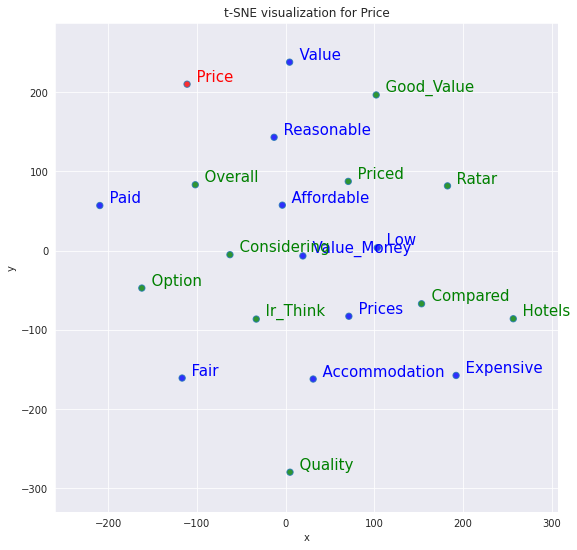

In [33]:
tsnescatterplot(w2v_model, 'price',[t[0] for t in w2v_model.wv.most_similar(positive=["price"], topn=20)][10:])

Vamos ver a diferença com as 30 principais palavras semelhantes.

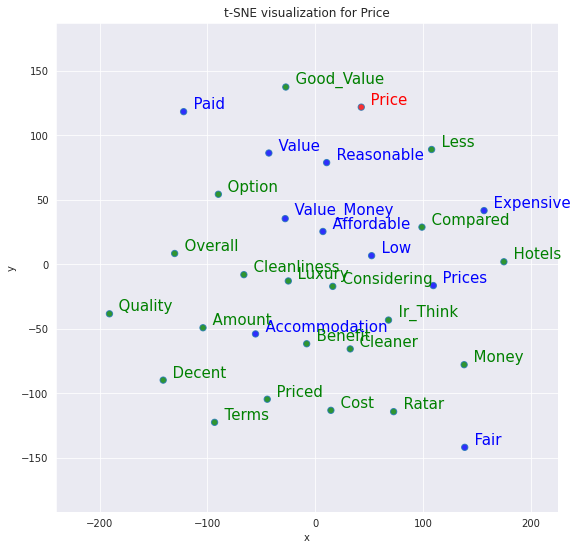

In [35]:
tsnescatterplot(w2v_model, 'price',[t[0] for t in w2v_model.wv.most_similar(positive=["price"], topn=30)][10:])

**Vamos ver se funciona com outras palavras**

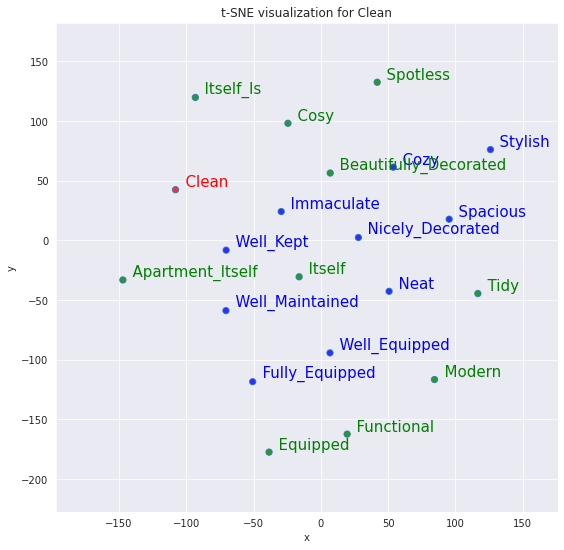

In [36]:
tsnescatterplot(w2v_model, 'clean',[t[0] for t in w2v_model.wv.most_similar(positive=["clean"], topn=20)][10:])

está novamente dando ótimos resultados.

vamos ver se funciona para algo aleatório

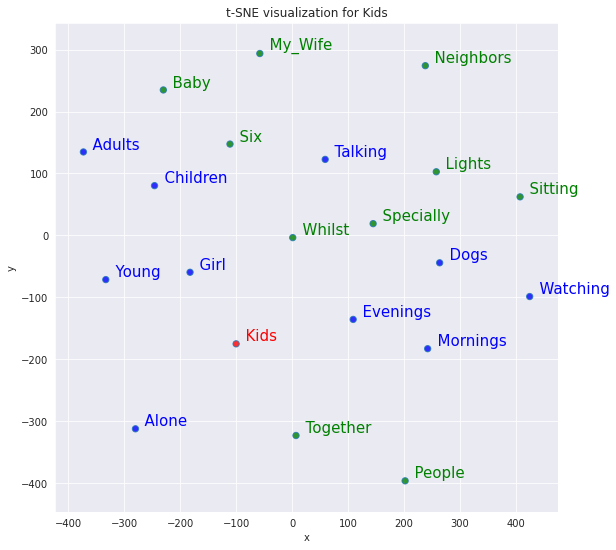

In [37]:
tsnescatterplot(w2v_model, 'kids',[t[0] for t in w2v_model.wv.most_similar(positive=["kids"], topn=20)][10:])